In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install MTCNN

Note: you may need to restart the kernel to use updated packages.


In [173]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive.zip"

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Data read-in and cleaning

import pandas as pd
lfw_allnames = pd.read_csv("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\mismatchpairsDevTrain.csv")
pairs = pd.read_csv("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\peopleDevTest.csv")
peopleDevTrain = pd.read_csv("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\peopleDevTrain.csv")

In [9]:
# shape data frame so there is a row per image, matched to relevant jpg file
import pandas as pd
from sklearn.model_selection import train_test_split
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",axis=1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",axis=1)
lfw_test = lfw_test.reset_index().drop("index",axis=1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

858
860


In [176]:
for file in files:
    path = "C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\lfw-deepfunneled\\lfw-deepfunneled\\" + file
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)


In [177]:
pd.DataFrame({'height':heights,'width':widths}).describe()

,height,width
count,52932.0,52932.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


<AxesSubplot:>

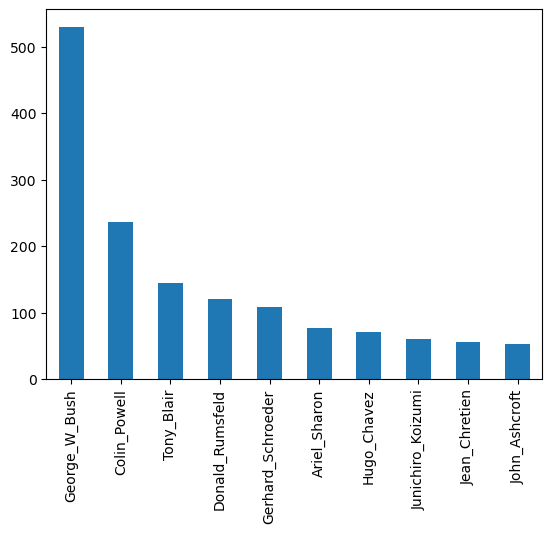

In [178]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [179]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


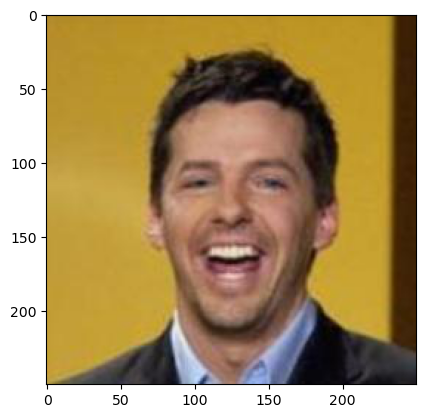

In [180]:
im = Image.open("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\lfw-deepfunneled\\lfw-deepfunneled\\" + str(lfw_train.image_path[0]))
plt.imshow(im)

1/1 [==============================] - 0s 297ms/step


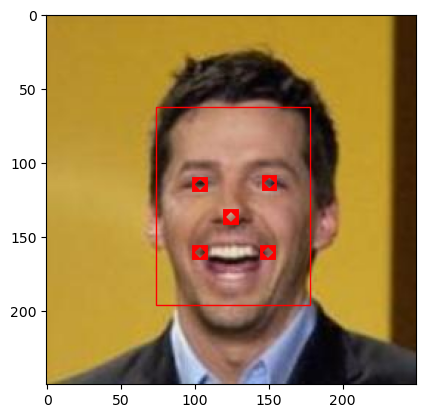

In [181]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mtcnn import MTCNN  # Import the MTCNN class

# Initialize the MTCNN detector
detector = MTCNN()

# Load the sample image
image_path = "C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\lfw-deepfunneled\\lfw-deepfunneled\\" + str(lfw_train.image_path[0])
image = cv2.imread(image_path)

# Detect faces in the image
result = detector.detect_faces(image)

# Get the bounding box and keypoints of the first detected face
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Plot the image with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig, ax = plt.subplots(1)
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display

# Create a Rectangle patch for the bounding box
rect = patches.Rectangle(bounding_box[0:2], bounding_box[2], bounding_box[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

# Visualize all the internal features (eyes, nose, and mouth corners)
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key], 1, 1, linewidth=10, edgecolor='r', facecolor='none')
    ax.add_patch(rect_key)

# Show the plot
plt.show()


In [182]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [183]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [184]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [185]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as 
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function 
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is 
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have 
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g. 
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())

# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [186]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name,data_type))
        path_from = os.path.join("C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\lfw-deepfunneled\\lfw-deepfunneled",image)
        path_to = os.path.join('/kaggle/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1        
    print('Moved {} images to {} folder.'.format(co,dir_name))


In [187]:
import os

# Specify the target directory path
target_directory = '/kaggle/working/Bush_train/'

# Create the target directory along with any missing parent directories
os.makedirs(target_directory, exist_ok=True)

In [188]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [10]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('/kaggle/working/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('/kaggle/working/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('/kaggle/working/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1480 images belonging to 2 classes.
Found 470 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


In [16]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have already defined and processed your training and validation data in 'Bush_training_set' and 'Bush_val_set'

# Initialize the classifier
Bush_classifier = Sequential()

# Add layers to the classifier (example architecture)
Bush_classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
Bush_classifier.add(MaxPooling2D(pool_size=(2, 2)))
Bush_classifier.add(Flatten())
Bush_classifier.add(Dense(units=128, activation='relu'))
Bush_classifier.add(Dense(units=1, activation='sigmoid'))

# Compile the classifier
Bush_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model
Bush_classifier.summary()

# Assuming you have already set up the paths to your training and validation data
train_data_dir ='/kaggle/working/Bush_train/' 
val_data_dir = '/kaggle/working/Bush_val/'

# Rescale the pixel values to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Set up the ImageDataGenerator for training and validation data
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary'
)

# Fit the classifier using the training and validation data
epochs = 8
steps_per_epoch = 678
validation_steps = 100

Bush_history = Bush_classifier.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

# Calculate the number of steps per epoch for training and validation generators
steps_per_epoch_train = len(train_generator) // batch_size
steps_per_epoch_val = len(val_generator) // batch_size

# Fit the classifier using the training and validation data
epochs = 8
Bush_history = Bush_classifier.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val
)
# Calculate the number of validation steps
validation_steps = len(val_generator) // batch_size

# Fit the classifier using the training and validation data
epochs = 8
Bush_history = Bush_classifier.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)












Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 30752)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               3936384   
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3937409 (15.02 MB)
Trainable params: 3937409 (15.02 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [19]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Validation accuracy not available. Make sure to provide validation data during training.


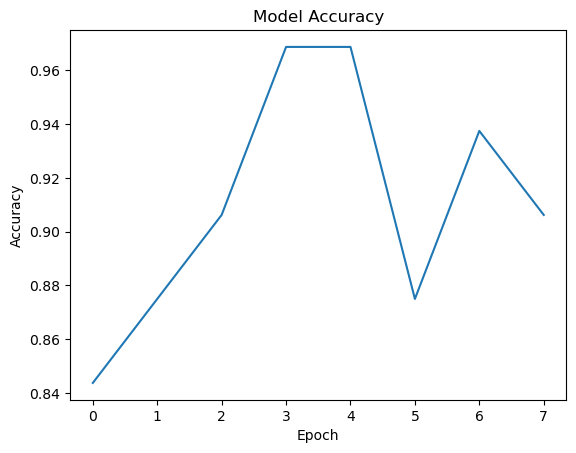

Epoch 1/8
1/1 [==============================] - 1s 747ms/step - loss: 0.3354 - accuracy: 0.8438
Epoch 2/8
1/1 [==============================] - 0s 353ms/step - loss: 0.2405 - accuracy: 0.8438
Epoch 3/8
1/1 [==============================] - 0s 336ms/step - loss: 0.2392 - accuracy: 0.8750
Epoch 4/8
1/1 [==============================] - 0s 324ms/step - loss: 0.2381 - accuracy: 0.9062
Epoch 5/8
1/1 [==============================] - 0s 324ms/step - loss: 0.2980 - accuracy: 0.8438
Epoch 6/8
1/1 [==============================] - 0s 323ms/step - loss: 0.3118 - accuracy: 0.8438
Epoch 7/8
1/1 [==============================] - 0s 342ms/step - loss: 0.2500 - accuracy: 0.9375
Epoch 8/8
1/1 [==============================] - 0s 449ms/step - loss: 0.2554 - accuracy: 0.9062


In [28]:
import matplotlib.pyplot as plt

# Assuming you have already trained the model and obtained the 'Bush_history' variable

# Plot the training accuracy and validation accuracy over epochs
plt.plot(Bush_history.history['accuracy'])
if 'val_accuracy' in Bush_history.history:
    plt.plot(Bush_history.history['val_accuracy'])
    plt.legend(['Train', 'Validation'], loc='upper left')
else:
    print("Validation accuracy not available. Make sure to provide validation data during training.")

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
epochs = 8
validation_steps = len(val_generator) // batch_size

Bush_history = Bush_classifier.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)



In [29]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [32]:
from collections import OrderedDict

# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
Bush_test_names = []
# collect all file names
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# extract unique names, in order
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

# Assuming you have already defined the 'Bush_test_names' list
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]

# Create an ordered list of unique test names
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))


In [36]:
import os
from tensorflow.keras.preprocessing import image

def predictions(file_path, classifier, binary=True):
    # file_path should include the name of the predicted individual - could edit this to iterate through folders in the future
    predictions = []
    for filename in os.listdir(file_path):
        file = os.path.join(file_path, filename)
        test_image = image.load_img(file, target_size=(250, 250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)
        if binary:
            result = classifier.predict(test_image)
            predictions.append(result[0][0])
        else:
            result = classifier.predict(test_image)
            predictions.append(result[0])
    return predictions




In [36]:
import os
from tensorflow.keras.preprocessing import image

def predictions(file_path, classifier, binary=True):
    # file_path should include the name of the predicted individual - could edit this to iterate through folders in the future
    predictions = []
    for filename in os.listdir(file_path):
        file = os.path.join(file_path, filename)
        test_image = image.load_img(file, target_size=(250, 250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)
        if binary:
            result = classifier.predict(test_image)
            predictions.append(result[0][0])
        else:
            result = classifier.predict(test_image)
            predictions.append(result[0])
    return predictions




In [38]:
# function for finding the precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy,precision,recall)

In [52]:
import os
import shutil



if "Bush_train" in os.listdir("./"):
    shutil.rmtree("./Bush_train")
if "Bush_val" in os.listdir("./"):
    shutil.rmtree("./Bush_val")
if "Bush_test" in os.listdir("./"):
    shutil.rmtree("./Bush_test")



In [54]:
# obtain 6 most common celebrities

image_paths['name'].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

In [55]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Assuming you have defined 'multi_data' containing the image data and labels
# Assuming you have imported the necessary libraries and loaded your data

# Define 'multi_data' as your dataset or array-like object
# For example:
multi_data = "C:\\Users\\MANTHRIYASHASHWINI\\Downloads\\archive\\lfw-deepfunneled\\lfw-deepfunneled" # Replace 'your_data' with your actual dataset or data array

# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split


# Split the data into training, validation, and test sets
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
multi_train, multi_val = train_test_split(multi_train, test_size=0.2)

# Same model setup as before
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3), activation='relu'))
multi_classifier.add(MaxPooling2D(pool_size=(2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units=128, activation='relu'))

# Output layer for binary classification with sigmoid activation
multi_classifier.add(Dense(units=1, activation='sigmoid'))

# Compile the model with binary_crossentropy loss for binary classification
multi_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Move images to separate directories (assuming you have the 'directory_mover' function defined)

# Data augmentation and normalization for training set
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only normalization for validation and test sets
val_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

multi_training_set = train_datagen.flow_from_directory(
    '/kaggle/working/Bush_train/',  # Update this path to the directory containing training images
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'  # Update class_mode to 'binary' for binary classification
)

multi_val_set = val_test_datagen.flow_from_directory(
    '/kaggle/working/Bush_val/',  # Update this path to the directory containing validation images
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'  # Update class_mode to 'binary' for binary classification
)

multi_test_set = val_test_datagen.flow_from_directory(
    '/kaggle/working/Bush_test/',  # Update this path to the directory containing test images
    target_size=(250, 250),
    batch_size=32,
    class_mode='binary'  # Update class_mode to 'binary' for binary classification
)

# Train the model using the fit_generator method (or fit for recent Keras versions)
multi_history = multi_classifier.fit_generator(
    multi_training_set,
    steps_per_epoch=len(multi_training_set),
    epochs=14,
    validation_data=multi_val_set,
    validation_steps=len(multi_val_set)
)

# Evaluate the model on the final test data
test_results = multi_classifier.evaluate_generator(
    multi_test_set,
    steps=len(multi_test_set)
)

print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


Found 1480 images belonging to 2 classes.
Found 470 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


C:\Users\MANTHRIYASHASHWINI\AppData\Local\Temp\ipykernel_17968\3094431185.py:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  multi_history = multi_classifier.fit_generator(


Epoch 1/14
47/47 [==============================] - 118s 2s/step - loss: 2.1956 - accuracy: 0.6236 - val_loss: 0.6525 - val_accuracy: 0.6000
Epoch 2/14
47/47 [==============================] - 91s 2s/step - loss: 0.5511 - accuracy: 0.7284 - val_loss: 0.6320 - val_accuracy: 0.6340
Epoch 3/14
47/47 [==============================] - 100s 2s/step - loss: 0.4839 - accuracy: 0.7804 - val_loss: 0.4127 - val_accuracy: 0.8149
Epoch 4/14
47/47 [==============================] - 96s 2s/step - loss: 0.3843 - accuracy: 0.8331 - val_loss: 0.3749 - val_accuracy: 0.8085
Epoch 5/14
47/47 [==============================] - 105s 2s/step - loss: 0.3312 - accuracy: 0.8534 - val_loss: 0.2988 - val_accuracy: 0.8574
Epoch 6/14
47/47 [==============================] - 100s 2s/step - loss: 0.3047 - accuracy: 0.8716 - val_loss: 0.2583 - val_accuracy: 0.9043
Epoch 7/14
47/47 [==============================] - 95s 2s/step - loss: 0.2504 - accuracy: 0.8993 - val_loss: 0.2150 - val_accuracy: 0.9213
Epoch 8/14
47/47

C:\Users\MANTHRIYASHASHWINI\AppData\Local\Temp\ipykernel_17968\3094431185.py:78: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_results = multi_classifier.evaluate_generator(


Test Loss: 0.19035010039806366
Test Accuracy: 0.9301533102989197
